In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
# and of course the actual regression (machine learning) module
from sklearn import linear_model


In [7]:
data = pd.read_csv('1.02.+Multiple+Linear+Regression.csv')
data.describe()

,SAT,GPA,"Rand 1,2,3"
count,84.000000,84.000000,84.000000
mean,1845.273810,3.330238,2.059524
std,104.530661,0.271617,0.855192
min,1634.000000,2.400000,1.000000
25%,1772.000000,3.190000,1.000000
50%,1846.000000,3.380000,2.000000
75%,1934.000000,3.502500,3.000000
max,2050.000000,3.810000,3.000000


In [32]:
#84 samples
x = data[['SAT','Rand 1,2,3']]
y = data['GPA']

In [9]:
#Initialize the regression
reg = LinearRegression()
# Fitting the regression with our data
reg.fit(x,y)

LinearRegression()

In [13]:
#One coefficent for each feature
reg.coef_

array([ 0.00165354, -0.00826982])

In [12]:
reg.intercept_

0.29603261264909486

In [16]:
#Calculate the R-squared
reg.score(x,y)

0.40668119528142843

### Formula for Adjusted R-squared: 

$R^2_{adj.} = 1 - (1-R^2)*\frac{n-1}{n-p-1}$


In [22]:
x.shape
# n = the number of observations
# p = the number of predictors

(84, 2)

In [26]:
Radj = 1-(1-reg.score(x,y))*((x.shape[0]-1)/(x.shape[0]-x.shape[1]-1))
Radj

0.39203134825134023

In [29]:
#Checking if it is correct
y = data['GPA']
x1 = data[['SAT','Rand 1,2,3']]
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GPA   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     27.76
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           6.58e-10
Time:                        16:48:49   Log-Likelihood:                 12.720
No. Observations:                  84   AIC:                            -19.44
Df Residuals:                      81   BIC:                            -12.15
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2960      0.417      0.710      0.480      -0.533       1.125
SAT            0.0017      0.000      7.432      0.000       0.001       0.002
Rand 1,2,3    -0.0083      0.027     -0.304      0.762      -0.062       0.046
==============================================================================
Omnibus:                       12.992   Durbin-Watson:                   0.948
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.364
Skew:                          -0.731   Prob(JB):                     0.000280
Kurtosis:                       4.594   Cond. No.                     3.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Feature Selection (F-regression)
## How do we detect the variables which are unneeded in a model?
With Feature Selection, it simplifies models. We improve speed and reduce errors from having too many features that are not useful

# feature_selection.f_regression
F-regression creates simple linear regression of each feature and the dependent variable. In this case we would have two, one that tries to compute GPA with SAT and the other one the same but using Rand 1,2,3 instead of SAT.

Note that for a simple linear regression, the p-value of F-stat **coincides** with the p-value of the only independent variable.

In [30]:
from sklearn.feature_selection import f_regression

In [33]:
f_regression(x,y)

(array([56.04804786,  0.17558437]), array([7.19951844e-11, 6.76291372e-01]))

In [34]:
p_values = f_regression(x,y)[1]
p_values

array([7.19951844e-11, 6.76291372e-01])

In [35]:
p_values.round(3)

array([0.   , 0.676])

The p-values of the 2 features:

*SAT* has a p-value of **0.** and *Rand 1,2,3* has a p-value of **0.676**

SAT is a useful variable where Rand 1,2,3 is useless. These are the univariate p-values reached from simple linear models but they do **NOT** reflect the interconnection of the features in our multiple linear regression

In [44]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1, positive=False):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive
    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [45]:
# When we create the regression everything is the same
reg_with_pvalues = LinearRegression()
reg_with_pvalues.fit(x,y)

LinearRegression()

In [46]:
# The difference is that we can check what's contained in the local variable 'p' in an instance of the LinearRegression() class
reg_with_pvalues.p

array([0.        , 0.75717067])

#### Creating a Summary Table

In [50]:
reg_summary = pd.DataFrame(data = x.columns.values, columns = ['Features'])
reg_summary

,Features
0,SAT
1,"Rand 1,2,3"


In [51]:
reg_summary ['Coefficients'] = reg.coef_

In [52]:
reg_summary ['p-values'] = p_values.round(3)

In [53]:
reg_summary

,Features,Coefficients,p-values
0,SAT,0.001654,0.000
1,"Rand 1,2,3",-0.008270,0.676


Rand 1,2,3 does not contribute to our model and should be removed. Being its coefficient bigger it doesn't mean its more important because SAT values are way higher than Rand 1,2,3

P-values are one of the best ways to determine if a variable is redundant, but they no provide info on HOW USEFUL a variable is

## Feature Scaling (Standarization)

Process of transforming data into a standard style.

How do we do that? By substracting the mean of the original variable $\mu$ and dividing by the standard deviation of the original variable $\sigma$.

Standarized variable = $\frac{x-\mu}{\sigma}$

We will always obtain a distribution with the mean = 0 and the standard deviation = 1

In [54]:
data

,SAT,GPA,"Rand 1,2,3"
0,1714,2.40,1
1,1664,2.52,3
2,1760,2.54,3
3,1685,2.74,3
4,1693,2.83,2
...,...,...,...
79,1936,3.71,3
80,1810,3.71,1
81,1987,3.73,3
82,1962,3.76,1


In [55]:
x,y

(     SAT  Rand 1,2,3
 0   1714           1
 1   1664           3
 2   1760           3
 3   1685           3
 4   1693           2
 ..   ...         ...
 79  1936           3
 80  1810           1
 81  1987           3
 82  1962           1
 83  2050           2
 
 [84 rows x 2 columns],
 0     2.40
 1     2.52
 2     2.54
 3     2.74
 4     2.83
       ... 
 79    3.71
 80    3.71
 81    3.73
 82    3.76
 83    3.81
 Name: GPA, Length: 84, dtype: float64)

In [56]:
from sklearn.preprocessing import StandardScaler

In [58]:
#Create an empty StandardScaler object, it will substract the mean and divide by the standard deviation
scaler = StandardScaler()

In [59]:
#Fit our input data
scaler.fit(x)

StandardScaler()

In [60]:
#.transform(x) trasnforms the unscaled inputs using the info contained in the scaler object
x_scaled = scaler.transform(x)

## Feature Selection through Standarization of Weights

In [61]:
reg = LinearRegression()

In [62]:
reg.fit(x_scaled,y)

LinearRegression()

In [63]:
reg.coef_

array([ 0.17181389, -0.00703007])

In [64]:
reg.intercept_

3.330238095238095

In [68]:
reg_summary = pd.DataFrame([['Bias'],['SAT'],['Rand 1,2,3']], columns = ['Features'])
reg_summary['Weights'] = reg.intercept_, reg.coef_[0], reg.coef_[1]

In [69]:
reg_summary

,Features,Weights
0,Bias,3.330238
1,SAT,0.171814
2,"Rand 1,2,3",-0.007030


THE BIGGER THE WEIGHT, THE BIGGER THE IMPACT OF THE COEFFICIENT, THE BIGGER THE IMPACT OF THE VARIABLE ON THE REGRESSION. The closer a weight is to 0, the smaller its impact; the bigger the weight, the bigger its impact

In ML, **bias** is the intercept and **weights** are the coefficients

Rand 1,2,3 barely contributes to the output

So we will use feature selection through standarization of the weights

When we perform feature scaling, we don't care if a feature is useless or not. They are automatically penalized for having a small weight, but it is better to remove them

## Predicting with the standardized coefficients

In [78]:
new_data = pd.DataFrame(data=[[1700,2],[1800,1]], columns = ['SAT','Rand 1,2,3'])
new_data

,SAT,"Rand 1,2,3"
0,1700,2
1,1800,1


In [79]:
reg.predict(new_data)

C:\Users\fxgibert\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([295.39979563, 312.58821497])

These values do not make any sense because they are normalized. Our model expects values taht are of the same magnitude as the ones used in the training process. The new data frame should be arrange in the same way as the input x_scaled. We need to scale it!

In [80]:
new_data_scaled = scaler.transform(new_data)
new_data_scaled

array([[-1.39811928, -0.07002087],
       [-0.43571643, -1.24637147]])

In [81]:
reg.predict(new_data_scaled)

array([3.09051403, 3.26413803])

## What if we removed the 'Random 1,2,3' variable?

In [104]:
x = data['SAT']
y = data['GPA']

In [90]:
x = x.values.reshape(-1,1)

In [91]:
scaler.fit(x)

StandardScaler()

In [97]:
x_scaled = scaler.transform(x)

In [98]:
reg.fit(x_scaled,y)

LinearRegression()

In [99]:
new_data = pd.DataFrame(data=[[1700],[1800]], columns = ['SAT'])
new_data

,SAT
0,1700
1,1800


In [100]:
reg.predict(new_data)

C:\Users\fxgibert\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([295.79297173, 312.99666194])

In [101]:
new_data_scaled = scaler.transform(new_data)
new_data_scaled

C:\Users\fxgibert\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[-1.39811928],
       [-0.43571643]])

In [102]:
reg.predict(new_data_scaled)

array([3.08970998, 3.25527879])

##### Other way to do it

In [105]:
reg_simple = LinearRegression()
x_simple_matrix = x_scaled[:,0].reshape(-1,1)
#it will grab all the values of the SAT column

In [106]:
reg_simple.fit(x_simple_matrix,y)

LinearRegression()

In [109]:
reg_simple.predict(new_data_scaled[:,0].reshape(-1,1))

array([3.08970998, 3.25527879])

## Overfitting/Underfitting and how we deal with it?

**Overfitting:** Our training has focused so much on the particular training set that has "missed the point". We capture the noise model


**Underfitting:** The model has not captured the underlying logic of the data. They are clumsy and have low accuracy, no relationships to be found or maybe an another model is needed.

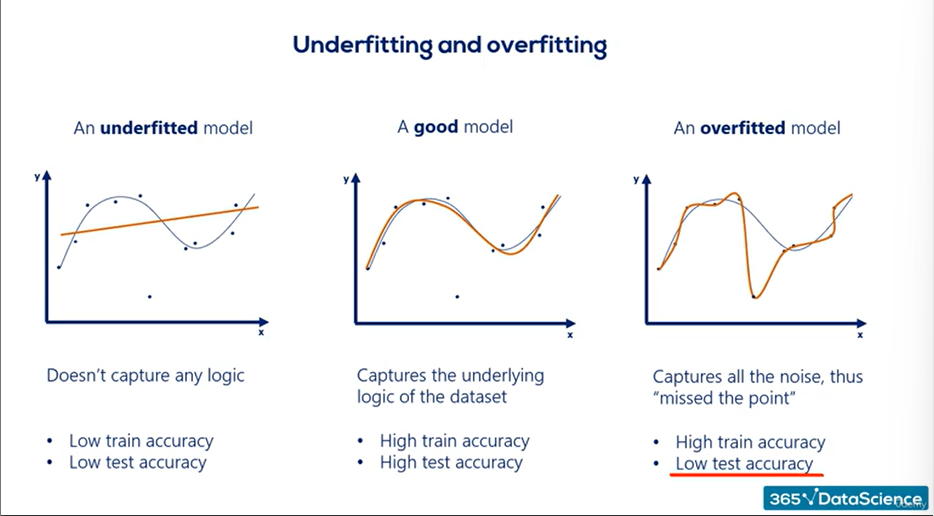

## Train Test Split

In [110]:
import numpy as np
from sklearn.model_selection import train_test_split

In [111]:
a = np.arange(1,101)

In [112]:
b = np.arange(501,601)

### Split the data

In [113]:
train_test_split(a)

[array([ 1, 23, 36, 18, 88, 33, 87, 50, 38, 42,  4, 63, 29, 40,  9, 47, 85,
        22, 20, 76, 30, 96, 72, 92, 49, 41, 79, 95, 78, 80,  3, 13, 61,  5,
        10, 34, 26, 32, 90, 58, 57, 24, 28, 31, 89, 35, 64, 60, 39,  6, 75,
        16, 68, 65, 53, 17, 54, 71, 74, 97, 25, 15, 83, 48, 70,  2, 52, 21,
        45, 93, 51, 69, 98, 94, 19]),
 array([ 43,  37,  86,  27,  77,  81,  12,  84,  14,  59, 100,  91,  55,
          8,  46,  44,  56,  67,  11,  99,  66,  62,  82,  73,   7])]

In [132]:
# random_state = 42 ensures the same shuffle for each iteration
a_train, a_test, b_train, b_test = train_test_split(a, b, test_size = 0.2, random_state = 42)

In [133]:
#Normally we prefer to shuffle the data
a_train.shape, a_test.shape

((80,), (20,))

In [134]:
b_train, b_test

(array([556, 589, 527, 543, 570, 516, 541, 597, 510, 573, 512, 548, 586,
        529, 594, 506, 567, 566, 536, 517, 550, 535, 508, 596, 528, 520,
        582, 526, 563, 514, 525, 504, 518, 539, 509, 579, 507, 565, 537,
        590, 557, 600, 555, 544, 551, 568, 547, 569, 562, 598, 580, 542,
        559, 549, 599, 558, 576, 533, 595, 560, 564, 585, 538, 530, 502,
        553, 522, 503, 524, 588, 592, 575, 587, 583, 521, 561, 572, 515,
        593, 552]),
 array([584, 554, 571, 546, 545, 540, 523, 581, 511, 501, 519, 531, 574,
        534, 591, 505, 577, 578, 513, 532]))